# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os

!pip install scipy
import scipy.stats as stats

!pip install papermill
!pip install nbconvert
!pip install nbformat
!pip install IPython

import papermill as pm
import nbformat
from nbconvert import HTMLExporter
from IPython.display import HTML, display

import json
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os
from scipy import stats
from scipy.stats import zscore

!pip install missingno
import missingno as msno

!pip install fancyimpute
import fancyimpute

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
import os
from dotenv import load_dotenv

# Find and load the .env file from the current or parent directories
load_dotenv()

# Access the environment variable using os.getenv()
PROJECT_PATH = os.getenv('PROJECT_PATH')
CONFIG_FILE = f"{PROJECT_PATH}/src/config.json"

In [4]:
drive.mount('/content/drive')

with open(CONFIG_FILE, 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
np.random.seed(31071967)

# Run project notebook N-1

In [6]:
if project_config['chain_notebooks'] == '1':

  input_file = f"{PROJECT_PATH}{project_config['notebooks_directory']}{project_config['notebook2']}"
  output_file = f"{PROJECT_PATH}{project_config['output_directory']}{project_config['output2']}"

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = input_file,
      output_path = output_file,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_file, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

Output hidden; open in https://colab.research.google.com to view.

# Load pickel

In [7]:
pickle_file      = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle1']
test_pickle_file = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle1_test']

In [8]:
# Read pickle into DataFrame
df = pd.read_pickle(pickle_file)
display(df.head(1))

if project_config['split_df'] == '1':
  df_test = pd.read_pickle(test_pickle_file)
  display(df_test.tail(1))

,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade_mean_popularity,release_month_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
26210,6GnhWMhgJb7uyiiPEiEkDA,Mac Miller,77,2Tyx5dLhHYkx6zeAdVaTzN,2ujrP2rPxu8ao7wNeG1ZOY,0.843,0.435,G♯/A♭,-8.442,Major,...,43.817673,44.145998,35.485437,Soul & Big Room EDM,67.933333,77.0,39.895522,42.769249,44.744681,32.370314


,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade_mean_popularity,release_month_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
20687,4vp2J1l5RD4gMZwGFLfRAu,The Black Eyed Peas,69,36fdxiOzdlmsrHgGcfvqUJ,6a66cg3HcsjYkisYyQcov6,0.743,0.766,C,-6.375,Major,...,33.36481,38.1139,28.538012,Electro/Latin Pop Fusion,56.625,69.0,58.826087,42.573333,41.820202,43.353232


In [9]:
# types of cols
small_cat_cols     = ['mode_mean_popularity','key_mean_popularity', 'playlist_genre_grouped_mean_popularity','release_decade_mean_popularity','release_month_mean_popularity']
small_cat_symboles = ['mode','key','playlist_genre_grouped','release_decade','release_month', 'release_year']
large_cat_cols     = ['track_artist_mean_popularity','track_album_id_mean_popularity','playlist_id_mean_popularity']
cont_cols          = ['acousticness', 'danceability','duration_ms','energy', 'liveness', 'loudness', 'speechiness', 'tempo','valence']
y_col              = 'track_popularity'
x_cols             = large_cat_cols + small_cat_cols + cont_cols
MERGE_ON_COL       = 'track_id'

# Outliers detection



In [10]:
cols_to_check_for_outliers = cont_cols

In [11]:
# keep a copy for before&after plots
df_with_outliers = df.copy()

In [12]:
if project_config['outliers_alg'] == 'IQR':

  multiplier = 1.5
  total_outliers_repleced = 0

  for col in cols_to_check_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    mask = (df[col] < lower) | (df[col] > upper)

    # Replace outliers
    df.loc[mask, col] = np.nan
    total_outliers_repleced += mask.sum()

    print(f"{col}: replaced {mask.sum()} outliers")

  print(f"\nA total of {total_outliers_repleced} cells replaced with NaN")

In [13]:
def identify_outliers_with_mad(df, cols_to_check_for_outliers, impute_with='NaN'):

  total_outliers_repleced = 0

  for col in cols_to_check_for_outliers:

  #identify outliers using MAD
    median = df[col].median()
    mad = np.median(np.abs(df[col] - median))
    modified_z = 0.6745 * (df[col] - median) / mad

    mask = np.abs(modified_z) > 3

  # replace with NaN
    df.loc[mask, col] = np.nan
    total_outliers_repleced += mask.sum()
    print(f"{col}: replaced {mask.sum()} outliers, using a modified_z threshold of {3}")

  print(f"\nA total of {total_outliers_repleced} cells replaced with NaN")

##########################################################################
if project_config['outliers_alg'] == 'MAD':
  identify_outliers_with_mad(df, cols_to_check_for_outliers, impute_with='NaN')

  if project_config['split_df'] == '1':
    identify_outliers_with_mad(df_test, cols_to_check_for_outliers, impute_with='NaN')

In [14]:
if project_config['outliers_alg'] == 'Z_SCORE':

  # compute z-scores
  Z_score = np.abs(stats.zscore(df[cols_to_check_for_outliers], nan_policy='omit'))

  # create a mask of True where Z > 3
  mask = Z_score > outliers_detection_threshold

  # count replaced cells per column
  replaced_counts = mask.sum(axis=0)

  # pretty print with column names
  print(f"{replaced_counts.sum()} cells replaced with NaN (Z > 3):")
  for col, count in zip(cols_to_check_for_outliers, replaced_counts):
      print(f"{col}: {count}")

  # actually replace with NaN
  df[cols_to_check_for_outliers] = df[cols_to_check_for_outliers].mask(mask)

In [15]:
def identify_outliers_with_iso(df, cols_to_check_for_outliers, impute_with='NaN'):

  # Fit Isolation Forest
  iso = IsolationForest(contamination=0.05, random_state=42)
  df['outlier_iso'] = iso.fit_predict(df[cols_to_check_for_outliers])

  # Label outliers
  outliers_iso = df[df['outlier_iso'] == -1]
  print(f"IsolationForest found {len(outliers_iso)} outliers")

  # Replace outlier values with NaN
  for col in cols_to_check_for_outliers:
    mask = df['outlier_iso'] == -1 # -1 if 'iso' in outlier_col or 'lof' in outlier_col else df[outlier_col] == 1
    df.loc[mask, col] = np.nan

  df.drop('outlier_iso', axis=1, inplace=True)


###############################################################################
if project_config['outliers_alg'] == 'ISO':

  from sklearn.ensemble import IsolationForest

  identify_outliers_with_iso(df, cols_to_check_for_outliers, impute_with='NaN')

  if project_config['split_df'] == '1':
    identify_outliers_with_iso(df_test, cols_to_check_for_outliers, impute_with='NaN')


In [16]:
def identify_outliers_with_lof(df, cols_to_check_for_outliers, impute_with='NaN'):

  num_cols = df.select_dtypes(include='number').columns

  lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
  df['outlier_lof'] = lof.fit_predict(df[cols_to_check_for_outliers])

  # Label outliers
  outliers_lof = df[df['outlier_lof'] == -1]
  print(f"LOF found {len(outliers_lof)} outliers. Inputing with {impute_with}")

   # Replace outlier values with NaN
  for col in cols_to_check_for_outliers:
    mask = df['outlier_lof'] == -1 # -1 if 'iso' in outlier_col or 'lof' in outlier_col else df[outlier_col] == 1
    df.loc[mask, col] = np.nan

  df.drop('outlier_lof', axis=1, inplace=True)


##################################################################################
if project_config['outliers_alg'] == 'LOF':

  from sklearn.neighbors import LocalOutlierFactor

  identify_outliers_with_lof(df, cols_to_check_for_outliers, impute_with='NaN')

  if project_config['split_df'] == '1':
    identify_outliers_with_lof(df_test, cols_to_check_for_outliers, impute_with='NaN')


LOF found 1150 outliers. Inputing with NaN
LOF found 493 outliers. Inputing with NaN


In [17]:
def identify_outliers_with_dbscan(df, cols_to_check_for_outliers, impute_with='NaN'):

  # Scale features (important for DBSCAN)
  X_scaled = StandardScaler().fit_transform(df[cols_to_check_for_outliers])

  db = DBSCAN(eps=1.5, min_samples=10)
  labels = db.fit_predict(X_scaled)

  df['outlier_dbscan'] = (labels == -1).astype(int)

  outliers_dbscan = df[df['outlier_dbscan'] == 1]
  print(f"DBSCAN found {len(outliers_dbscan)} outliers")

  # Replace outlier values with NaN
  for col in cols_to_check_for_outliers:
    mask = df['outlier_dbscan'] == 1 #-1 if 'iso' in outlier_col or 'lof' in outlier_col else df[outlier_col] == 1
    df.loc[mask, col] = np.nan

  df.drop('outlier_dbscan', axis=1, inplace=True)

################################################################################
if project_config['outliers_alg'] == 'DBSCAN':

  from sklearn.cluster import DBSCAN
  from sklearn.preprocessing import StandardScaler

  identify_outliers_with_dbscan(df, cols_to_check_for_outliers, impute_with='NaN')

  if project_config['split_df'] == '1':
    identify_outliers_with_dbscan(df_test, cols_to_check_for_outliers, impute_with='NaN')

# Imputate

In [18]:
imputer = None
outliers_replacement = 'NaN'

In [19]:
df_with_nulls = df.copy() # keep for visualizations

In [20]:
if project_config['imputer_alg'] == 'MICE':

  from sklearn.experimental import enable_iterative_imputer  # noqa
  from fancyimpute import IterativeImputer  # MICE-like

  imputer = IterativeImputer(max_iter=15)
  df[x_cols] = imputer.fit_transform(df[x_cols])

if project_config['split_df'] == '1':
  imputer = IterativeImputer(max_iter=15)
  df_test[x_cols] = imputer.fit_transform(df_test[x_cols])

In [21]:
if project_config['imputer_alg'] == 'KNN':

  from fancyimpute import KNN
  imputer = KNN(k=5)
  df[cols_to_check_for_outliers] = imputer.fit_transform(df[cols_to_check_for_outliers])

In [22]:
# Find the cells that were NaN before
missing_mask = df_with_nulls.isna()

# Compare old (NaN) vs new (imputed) values
for col in x_cols:
    replaced_values = df.loc[missing_mask[col], col]
    if not replaced_values.empty:
        print(f"Column: {col} impute {len(replaced_values)+1} NaN cells with values")
        #for idx, new_val in replaced_values.items():
        #    print(f"Row {idx}: filled with {new_val:.3f}")

Column: track_artist_mean_popularity impute 4 NaN cells with values
Column: acousticness impute 1151 NaN cells with values
Column: danceability impute 1151 NaN cells with values
Column: duration_ms impute 1151 NaN cells with values
Column: energy impute 1151 NaN cells with values
Column: liveness impute 1151 NaN cells with values
Column: loudness impute 1151 NaN cells with values
Column: speechiness impute 1151 NaN cells with values
Column: tempo impute 1151 NaN cells with values
Column: valence impute 1151 NaN cells with values


# Visualize the result of cleansing

## Using ANOVA to validate distribution of each col along the cleansing process

In [23]:
results = []

for col in cols_to_check_for_outliers:

    groups = [
        df_with_outliers[col].dropna(),
        df_with_nulls[col].dropna(),
        df[col].dropna()
    ]

    # Check data validity before running ANOVA
    group_lengths = [len(g) for g in groups]
    unique_counts = [g.nunique() for g in groups]

    # Detect common problems
    if any(l < 2 for l in group_lengths):
        reason = "Too few samples in at least one group"
        f_stat, p_val = np.nan, np.nan
    elif all(u == 1 for u in unique_counts):
        reason = "All groups constant (no variance)"
        f_stat, p_val = np.nan, np.nan
    else:
        try:
            f_stat, p_val = stats.f_oneway(*groups)
            reason = (
                "Valid test" if np.isfinite(p_val)
                else "Invalid numeric result (possibly zero variance)"
            )
        except Exception as e:
            f_stat, p_val, reason = np.nan, np.nan, f"Error: {e}"

    results.append({
        "column along the process": col,
        "F_statistic": f_stat,
        "p_value": p_val,
        "significant": (p_val < 0.05) if np.isfinite(p_val) else False,
        "reason": reason
    })

anova_diagnostic = pd.DataFrame(results)
anova_diagnostic = anova_diagnostic.sort_values("p_value", na_position="last")

pd.set_option("display.float_format", "{:.4f}".format)
display(anova_diagnostic)

,column along the process,F_statistic,p_value,significant,reason
7,tempo,9.3396,0.0001,True,Valid test
1,danceability,1.2443,0.2882,False,Valid test
6,speechiness,1.2431,0.2885,False,Valid test
2,duration_ms,1.2267,0.2933,False,Valid test
3,energy,0.0347,0.9659,False,Valid test
0,acousticness,0.0168,0.9833,False,Valid test
8,valence,0.0087,0.9913,False,Valid test
4,liveness,0.0020,0.9980,False,Valid test
5,loudness,0.0009,0.9991,False,Valid test


## And Scatter plots

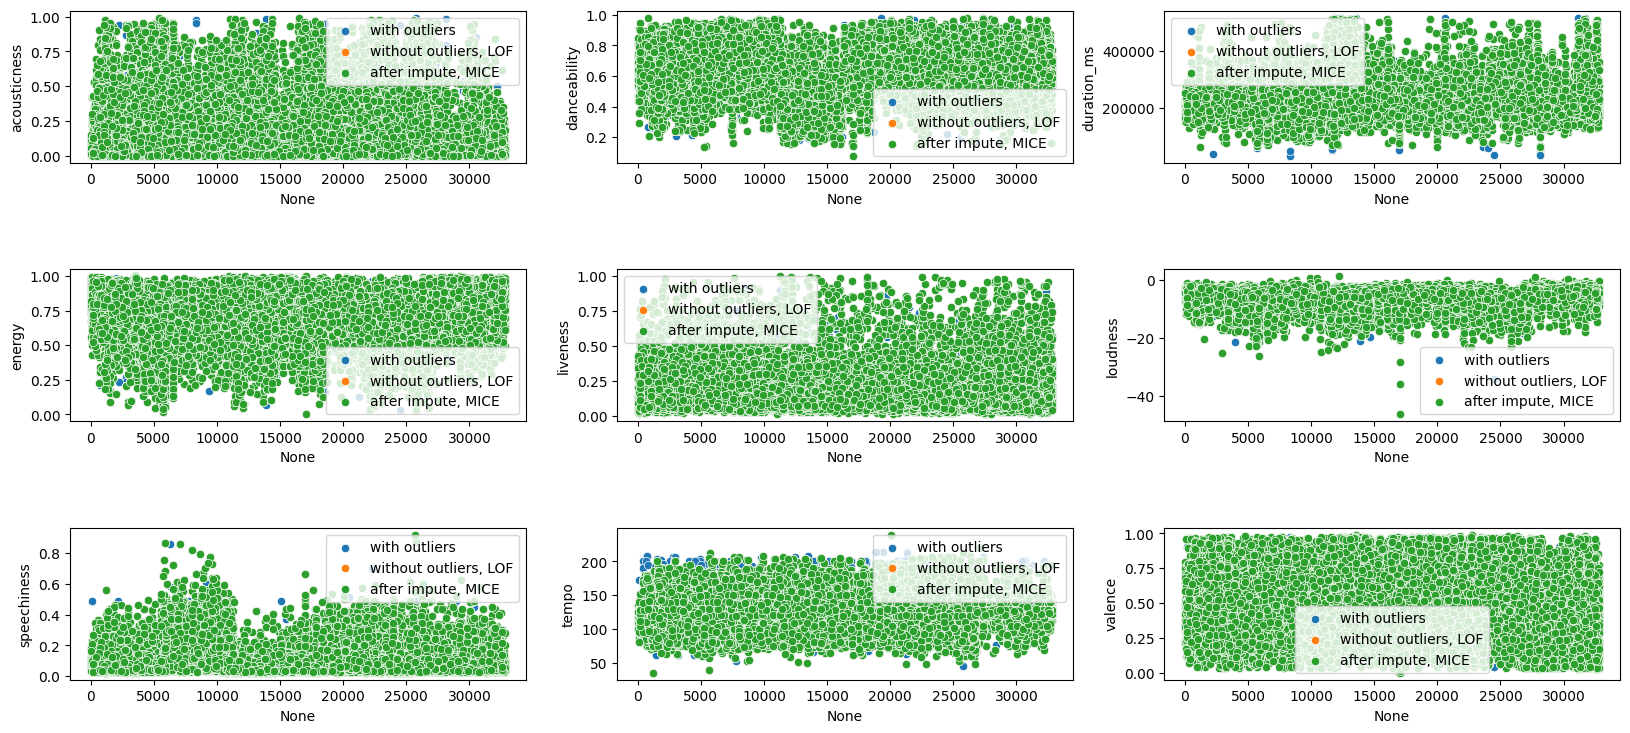

In [24]:
## scatterplots
plt.figure(figsize=(20,200))
for i, col in enumerate(df[cols_to_check_for_outliers], start=1):
  ax = plt.subplot(60, 3, i)
  sb.scatterplot(x=df_with_outliers.index, y=df_with_outliers[col], ax=ax, label='with outliers')
  sb.scatterplot(x=df_with_nulls.index, y=df_with_nulls[col], ax=ax, label=f"without outliers, {project_config['outliers_alg']}")
  sb.scatterplot(x=df.index, y=df[col], ax=ax, label=f"after impute, {project_config['imputer_alg']}")
  plt.subplots_adjust(hspace = 0.7)

plt.show()

# Much better now ✌

#  Pickle

In [25]:
from google.colab import files
import os

with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle3']}", 'wb') as f:
  pickle.dump(df, f)
  f.close()

if project_config['split_df'] == '1':
  with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle3_test']}", 'wb') as f:
    pickle.dump(df_test, f)
    f.close()

# Great 😀